In [7]:
from ecallisto_ng.data_download.hu_dataset import create_overlapping_parquets, load_radio_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import torch
import yaml
from datasets import DatasetDict, load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm

from datetime import timedelta, datetime, timezone
from ecallisto_dataset import EcallistoDatasetBinary, custom_resize, remove_background
from ecallisto_model import GrayScaleResNet

def create_logits(model: GrayScaleResNet, dataloader, device):
    model.eval()  # Ensure the model is in evaluation mode
    model.to(device)  # Send the model to the appropriate device
    binary_logits = []

    print("Starting prediction")
    with torch.no_grad():
        for inputs, _, _, _ in tqdm(dataloader):
            y_hat = model(inputs.to(device)).squeeze(dim=1)
            binary_logits.extend(y_hat.cpu().tolist())

    return binary_logits


def load_model(checkpoint_path, config_path):
    # Load configuration
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    # Initialize the model
    model = GrayScaleResNet(
        1,
        resnet_type=config["model"]["model_type"],
        optimizer_name="adam",
        learning_rate=1000,
        label_smoothing=0.0,
    )

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

    return model, config


def prepare_ecallisto_datasets(ds, config):
    resize_func = Compose(
        [lambda x: custom_resize(x, tuple(config["model"]["input_size"]))]
    )
    print("Wohoho")
    ds = ds.add_column("dummy_label", [0] * len(ds))
    edb = EcallistoDatasetBinary(
        ds,
        label_name="dummy_label",
        resize_func=resize_func,
        normalization_transform=remove_background,
    )
    return edb


def prepare_dataloaders(ds, batch_size):
    dataloader = DataLoader(
        ds, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    return dataloader


In [8]:
# Define repository and filename
repo_id = "i4ds/flaresense"
filename = "model.ckpt"
config_path  = "configs/relabeled_data_best.yml"
# Download the model file
checkpoint_path = hf_hub_download(repo_id=repo_id, filename=filename)


In [9]:
model, config = load_model(checkpoint_path, config_path)

/tmp/ipykernel_260019/2788497777.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [36]:
# Create UTC timestamp
datetime_now = datetime.now(timezone.utc).replace(tzinfo=None)

In [37]:
datetime_now-timedelta(hours=2)

datetime.datetime(2024, 12, 10, 14, 37, 33, 396573)

In [38]:
datetime_now

datetime.datetime(2024, 12, 10, 16, 37, 33, 396573)

In [39]:
import pandas as pd
import glob
from datasets import Dataset, Image
from PIL import Image as PILImage

import os
import pandas as pd
from datetime import datetime, timedelta
from ecallisto_ng.data_download.downloader import get_ecallisto_data
from tqdm import tqdm



def load_radio_dataset(base_path: str) -> Dataset:
    """
    Loads a radio dataset from parquet files located within the specified base path.

    This function searches for parquet files within the given base path, extracts
    metadata such as antenna information and datetime from the file paths, converts
    these data into a Pandas DataFrame, and then transforms it into a Hugging Face
    Dataset. It also reads image data from the parquet files and converts them into
    PIL images.

    Parameters
    ----------
    base_path : str
        The base directory path where the parquet files are located. The parquet files
        are expected to be in subdirectories named after antennas.

    Returns
    -------
    Dataset
        A Hugging Face Dataset object containing the image data and associated metadata.
    """

    images = glob.glob(f"{base_path}*/*.parquet")
    print(images)
    df = pd.DataFrame({"image": images})
    df["antenna"] = df["image"].apply(lambda x: x.split("/")[-2])
    df["datetime"] = df["image"].apply(
        lambda x: x.split("/")[-1].replace(".parquet", "")
    )
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d_%H-%M-%S")

    dataset = Dataset.from_pandas(df)

    def load_image_from_parquet(example):
        parquet_path = example["image"]
        df_parquet = pd.read_parquet(parquet_path)
        example["image"] = PILImage.fromarray(df_parquet.values.T)
        return example
    print(dataset)
    dataset = dataset.map(load_image_from_parquet)
    dataset = dataset.cast_column("image", Image())

    return dataset

In [40]:
create_overlapping_parquets(datetime_now-timedelta(hours=2), datetime_now, ['UNIGRAZ'], 'flaresense-data')
ds = load_radio_dataset('flaresense-data/')












[Instruments]: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


['flaresense-data/AUSTRIA-UNIGRAZ_02/2024-12-10_14-37-33.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_02/2024-12-10_14-45-34.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_02/2024-12-10_14-31-34.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_02/2024-12-10_14-51-33.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_02/2024-12-10_14-59-34.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_01/2024-12-10_14-37-33.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_01/2024-12-10_14-45-34.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_01/2024-12-10_14-31-34.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_01/2024-12-10_14-51-33.parquet', 'flaresense-data/AUSTRIA-UNIGRAZ_01/2024-12-10_14-59-34.parquet', 'flaresense-data/GERMANY-DLR_63/2024-12-10_14-31-34.parquet']
Dataset({
    features: ['image', 'antenna', 'datetime'],
    num_rows: 11
})


Map: 100%|██████████| 11/11 [00:05<00:00,  1.98 examples/s]


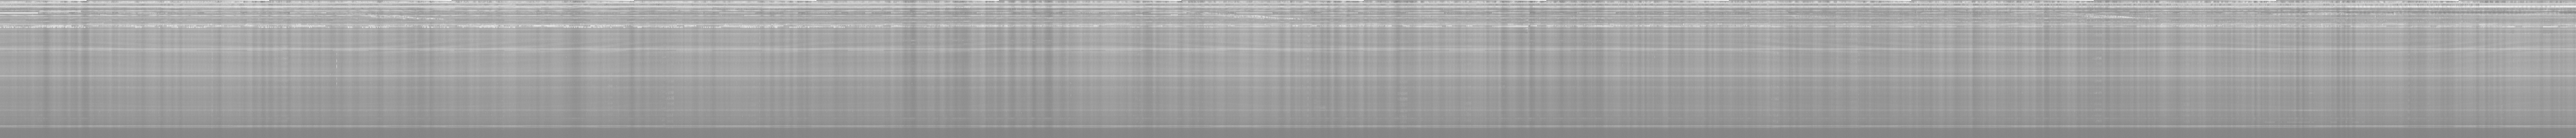

In [35]:
ds[0]['image']

In [19]:
ds